# Convolutional Forest Kappas Experiment (ConvRF)

The goal of this experiment is to demonstrate the capabilities of a convolutional forest against benchmarks such as naive random forests, simple CNN's, and more complex CNN's. We will perform 45 2-class Cifar classification tasks, and then plot the pairwise Cohen's Kappa Statistic differences between ConvRF vs naive RF, ConvRF vs simple CNN, and ConvRF vs more complex CNN.

Note: this experiment uses the class file and functions from `./functions/ConvRF.py`

In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import functions.ConvRF as ConvRF
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns

sns.set()
import warnings

warnings.filterwarnings("ignore")

## Set parameters

First we set the plotting figure parameters and some other multiprocessing necessities.

In [2]:
%matplotlib inline
plt.rcParams["legend.loc"] = "best"
plt.rcParams["figure.facecolor"] = "white"
names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

# filter python warnings
def run():
    torch.multiprocessing.freeze_support()


if __name__ == "__main__":
    run()

## Obtain CIFAR

Next we obtain the CIFAR dataset.

In [8]:
# prepare CIFAR data

# normalize
scale = np.mean(np.arange(0, 256))
normalize = lambda x: (x - scale) / scale

# train data
cifar_trainset = datasets.CIFAR10(root="./", train=True, download=True, transform=None)
cifar_train_images = normalize(cifar_trainset.data)
cifar_train_labels = np.array(cifar_trainset.targets)

# test data
cifar_testset = datasets.CIFAR10(root="./", train=False, download=True, transform=None)
cifar_test_images = normalize(cifar_testset.data)
cifar_test_labels = np.array(cifar_testset.targets)


# transform
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
trainset = datasets.CIFAR10(root="./", train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root="./", train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Define CNN

Next we define some CNN architectures. 

In [9]:
# define 3 CNN arhcitectures
class SimpleCNNOneFilter(nn.Module):
    def __init__(self):
        super(SimpleCNNOneFilter, self).__init__()
        self.conv1 = nn.Conv2d(3, 1, kernel_size=10, stride=2)
        self.fc1 = nn.Linear(144, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, 144)
        x = self.fc1(x)
        return x


class SimpleCNN32Filter(nn.Module):
    def __init__(self):
        super(SimpleCNN32Filter, self).__init__()
        self.conv1 = nn.Conv2d(
            3, 32, kernel_size=10, stride=2
        )  # try 64 too, if possible
        self.fc1 = nn.Linear(144 * 32, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, 144 * 32)
        x = self.fc1(x)
        return x


class SimpleCNN32Filter2Layers(nn.Module):
    def __init__(self):
        super(SimpleCNN32Filter2Layers, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=10, stride=2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=7, stride=1)
        self.fc1 = nn.Linear(36 * 32, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 36 * 32)
        x = self.fc1(x)
        return x

## Perform Experiment

Here we actually perform the experiments.

In [ ]:
# go through 45 combinations of experiments
res = {}
for class1 in range(10):
    for class2 in range(class1 + 1, 10):

        # accuracy vs num training samples (naive_rf)
        naive_rf_acc_vs_n = list()
        fraction_of_train_samples_space = np.geomspace(0.01, 1, num=8)
        for fraction_of_train_samples in fraction_of_train_samples_space:
            RF = RandomForestClassifier(n_estimators=100, n_jobs=-1)
            best_accuracy = np.mean(
                [
                    ConvRF.run_rf(
                        RF,
                        cifar_train_images,
                        cifar_train_labels,
                        cifar_test_images,
                        cifar_test_labels,
                        fraction_of_train_samples,
                        class1,
                        class2,
                    )
                    for _ in range(5)
                ]
            )
            naive_rf_acc_vs_n.append(best_accuracy)

        # accuracy vs num training samples (naive_rf)
        conv_rf_2_layer = list()
        for fraction_of_train_samples in fraction_of_train_samples_space:
            conv_rf_2l = ConvRF.ConvRFClassifier(
                layers=2, kernel_size=(10, 5), stride=(2, 1)
            )
            best_accuracy = np.mean(
                [
                    ConvRF.run_rf(
                        conv_rf_2l,
                        cifar_train_images,
                        cifar_train_labels,
                        cifar_test_images,
                        cifar_test_labels,
                        fraction_of_train_samples,
                        class1,
                        class2,
                    )
                    for _ in range(5)
                ]
            )
            conv_rf_2_layer.append(best_accuracy)

        # accuracy vs num training samples (naive_rf)
        conv_rf_apply = list()
        for fraction_of_train_samples in fraction_of_train_samples_space:
            conv_rf_a = ConvRF.ConvRFClassifier(
                layers=1, kernel_size=(10,), stride=(2,)
            )
            best_accuracy = np.mean(
                [
                    ConvRF.run_rf(
                        conv_rf_a,
                        cifar_train_images,
                        cifar_train_labels,
                        cifar_test_images,
                        cifar_test_labels,
                        fraction_of_train_samples,
                        class1,
                        class2,
                    )
                    for _ in range(5)
                ]
            )
            conv_rf_apply.append(best_accuracy)

        # accuracy vs num training samples (one layer cnn (32 filters))
        cnn32_acc_vs_n = list()
        for fraction_of_train_samples in fraction_of_train_samples_space:
            best_accuracy = np.mean(
                [
                    ConvRF.run_cnn(
                        SimpleCNN32Filter,
                        cifar_train_images,
                        cifar_train_labels,
                        cifar_test_images,
                        cifar_test_labels,
                        fraction_of_train_samples,
                        class1,
                        class2,
                        trainset,
                        testset,
                    )
                    for _ in range(5)
                ]
            )
            cnn32_acc_vs_n.append(best_accuracy)

        # accuracy vs num training samples (two layer cnn (32 filters))
        cnn32_two_layer_acc_vs_n = list()
        for fraction_of_train_samples in fraction_of_train_samples_space:
            best_accuracy = np.mean(
                [
                    ConvRF.run_cnn(
                        SimpleCNN32Filter2Layers,
                        cifar_train_images,
                        cifar_train_labels,
                        cifar_test_images,
                        cifar_test_labels,
                        fraction_of_train_samples,
                        class1,
                        class2,
                        trainset,
                        testset,
                    )
                    for _ in range(5)
                ]
            )
            cnn32_two_layer_acc_vs_n.append(best_accuracy)

        # accuracy vs num training samples (one layer cnn)
        cnn_acc_vs_n = list()
        for fraction_of_train_samples in fraction_of_train_samples_space:
            best_accuracy = np.mean(
                [
                    ConvRF.run_cnn(
                        SimpleCNNOneFilter,
                        cifar_train_images,
                        cifar_train_labels,
                        cifar_test_images,
                        cifar_test_labels,
                        fraction_of_train_samples,
                        class1,
                        class2,
                        trainset,
                        testset,
                    )
                    for _ in range(5)
                ]
            )
            cnn_acc_vs_n.append(best_accuracy)

        table = pd.DataFrame(
            np.concatenate(
                (
                    [naive_rf_acc_vs_n],
                    [conv_rf_apply],
                    [conv_rf_2_layer],
                    [cnn_acc_vs_n],
                    [cnn32_acc_vs_n],
                    [cnn32_two_layer_acc_vs_n],
                ),
                axis=0,
            )
        )
        algos = [
            "naiveRF",
            "convrf",
            "convrf2layer",
            "simplecnn",
            "cnn32",
            "cnn32_2layer",
        ]
        table["algos"] = algos
        cols = table.columns.tolist()
        cols = [cols[-1]] + cols[:-1]
        cols = pd.Index(cols)
        table = table[cols]
        res[str(class1) + "_vs_" + str(class2)] = table

## Define kappa plots

Here we define a function for plotting pairwise kappa differences.

In [ ]:
def plot_kappa(algo1, algo2):
    # convrf vs naiverf
    kappas_subtract = []
    xs = []
    for class1 in range(10):
        for class2 in range(class1 + 1, 10):
            results = res[str(class1) + "_vs_" + str(class2)]
            rf_err = 0.5 / (1 - results.iloc[algo2][1:])
            convrf_err = 0.5 / (1 - results.iloc[algo1][1:])
            kappa = convrf_err - rf_err
            kappas_subtract.extend(kappa)
            xs.extend([1, 2, 3, 4, 5, 6, 7, 8])

    ind1 = range(0, len(xs), 8)
    ind2 = range(1, len(xs), 8)
    ind3 = range(2, len(xs), 8)
    ind4 = range(3, len(xs), 8)
    ind5 = range(4, len(xs), 8)
    ind6 = range(5, len(xs), 8)
    ind7 = range(6, len(xs), 8)
    ind8 = range(7, len(xs), 8)

    plt.clf()
    for i in range(45):
        plt.plot(xs[i * 8 : i * 8 + 8], kappas_subtract[i * 8 : i * 8 + 8])
    plt.xticks(
        [1, 2, 3, 4, 5, 6, 7, 8],
        ["100", "194", "372", "720", "1390", "2682", "5180", "10000"],
    )
    plt.xlabel("Number of Train Samples")
    plt.ylabel("Kappa")
    plt.title(algos[algo1] + " - " + algos[algo2] + " kappa vs # of Train Samples")

    plt.figure()
    plt.clf()
    box1 = [(kappas_subtract[i]) for i in ind1]
    box2 = [(kappas_subtract[i]) for i in ind2]
    box3 = [(kappas_subtract[i]) for i in ind3]
    box4 = [(kappas_subtract[i]) for i in ind4]
    box5 = [(kappas_subtract[i]) for i in ind5]
    box6 = [(kappas_subtract[i]) for i in ind6]
    box7 = [(kappas_subtract[i]) for i in ind7]
    box8 = [(kappas_subtract[i]) for i in ind8]
    boxs = [box1, box2, box3, box4, box5, box5, box7, box8]

    plt.boxplot(boxs)
    plt.xlabel("Number of Train Samples")
    plt.ylabel("Kappa")
    plt.title(algos[algo1] + " - " + algos[algo2] + " kappa vs # of Train Samples")
    plt.xticks(
        [1, 2, 3, 4, 5, 6, 7, 8],
        ["100", "194", "372", "720", "1390", "2682", "5180", "10000"],
    )

## Plot kappa between ConvRF and NaiveRF

Now we plot the Kappa Statistic differences between ConvRF and naive RF.

([<matplotlib.axis.XTick at 0x2a526c774f0>,
 [Text(1, 0, '100'),
  Text(2, 0, '194'),
  Text(3, 0, '372'),
  Text(4, 0, '720'),
  Text(5, 0, '1390'),
  Text(6, 0, '2682'),
  Text(7, 0, '5180'),
  Text(8, 0, '10000')])

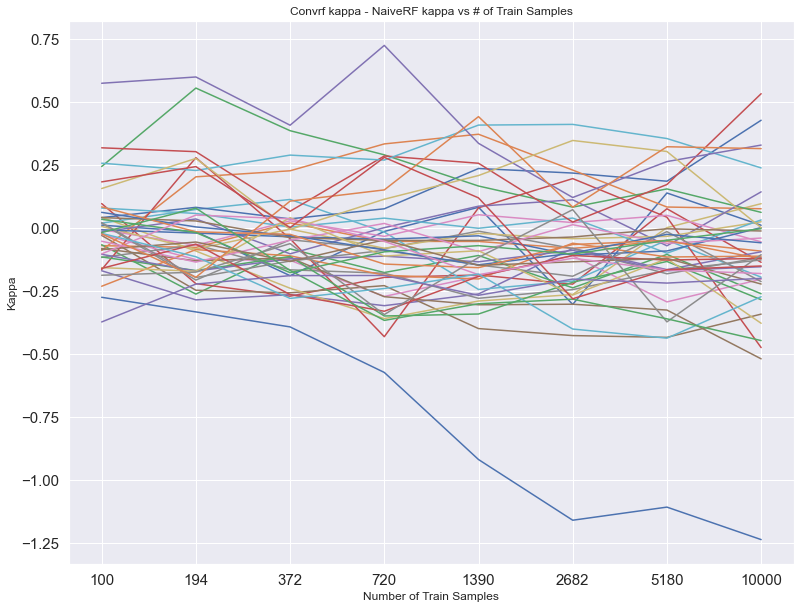

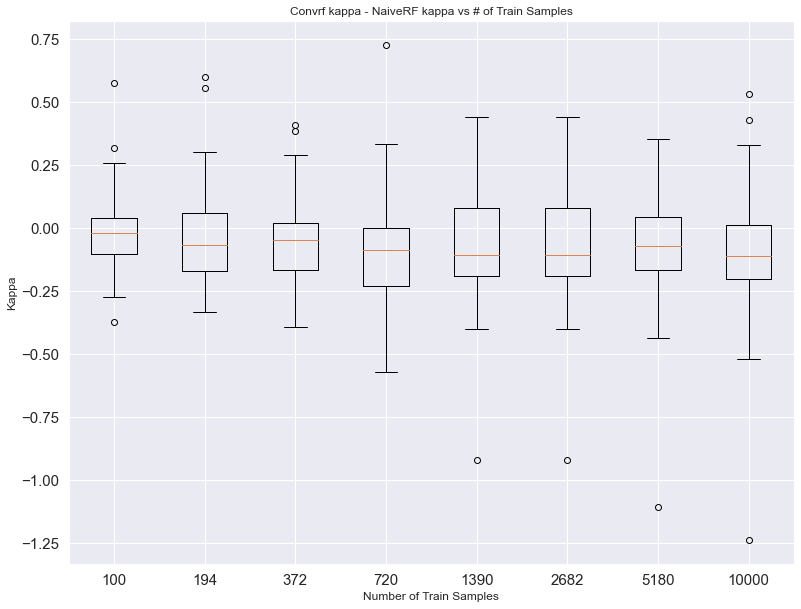

In [41]:
plot_kappa(1, 0)

## Plot kappa between ConvRF and SimpleCNN

Now we plot the Kappa Statistic differences between ConvRF and simple CNN.

([<matplotlib.axis.XTick at 0x2a5269d8610>,
 [Text(1, 0, '100'),
  Text(2, 0, '194'),
  Text(3, 0, '372'),
  Text(4, 0, '720'),
  Text(5, 0, '1390'),
  Text(6, 0, '2682'),
  Text(7, 0, '5180'),
  Text(8, 0, '10000')])

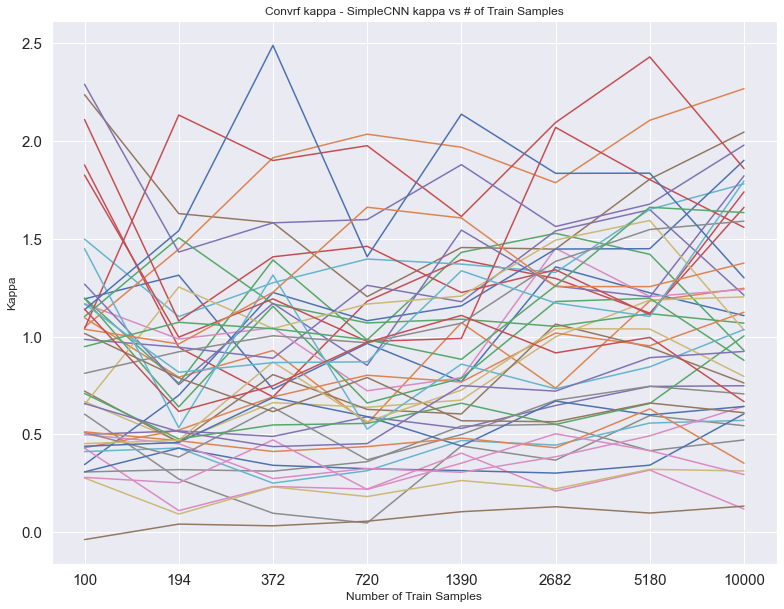

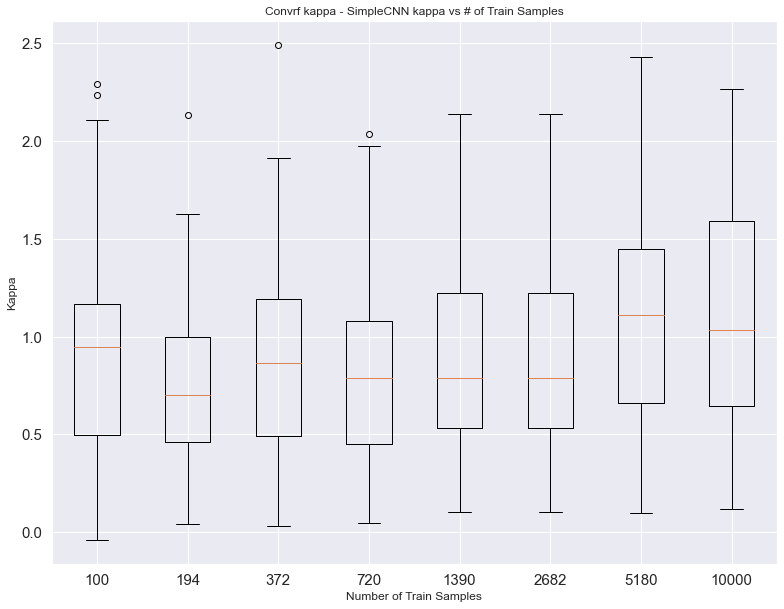

In [42]:
plot_kappa(1, 3)

## Plot kappa between ConvRF and complex CNN

Now we plot the Kappa Statistic differences between ConvRF and more complex CNN.

([<matplotlib.axis.XTick at 0x2a524e81550>,
 [Text(1, 0, '100'),
  Text(2, 0, '194'),
  Text(3, 0, '372'),
  Text(4, 0, '720'),
  Text(5, 0, '1390'),
  Text(6, 0, '2682'),
  Text(7, 0, '5180'),
  Text(8, 0, '10000')])

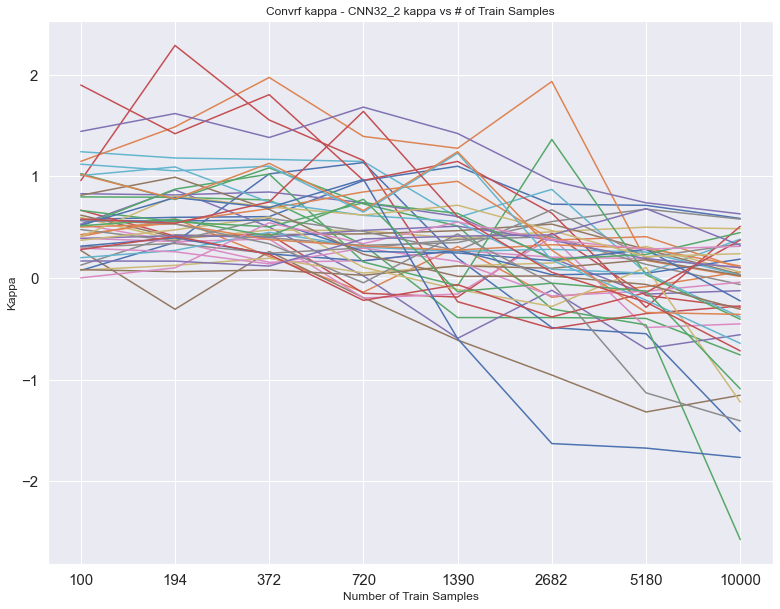

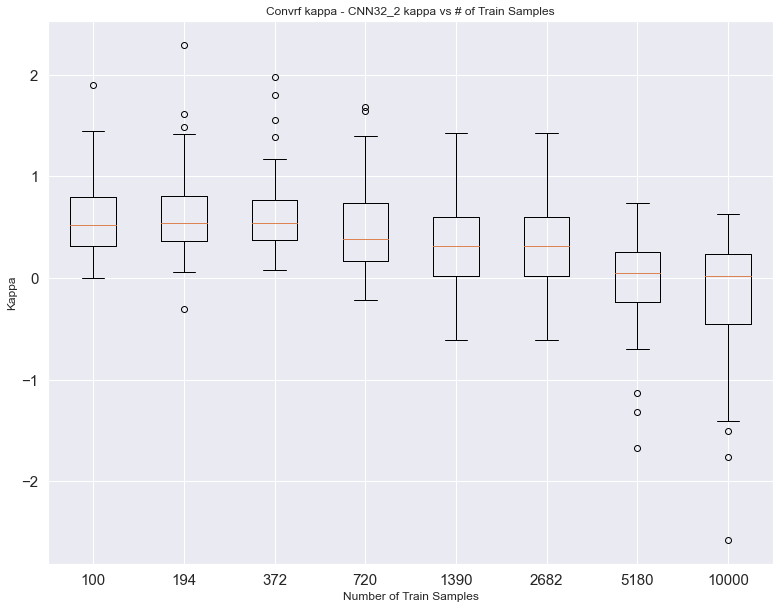

In [43]:
plot_kappa(1, 5)